In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings("ignore")

In [2]:
import torch

from PycalcAct.dataset import Dataset
from PycalcAct.model import (
    MixedFCTemporalModel,
)
from PycalcAct.trainer import Trainer

_ = torch.manual_seed(1234)


In [3]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",  # Optional
    position_to_displacement=True,
    remove_mean=False,
    replace_nan_by_min=True,
    # Convert the x, y position to a single displacement value (sqrt((x(t+1)-x(t))^2 + (y(t+1)-y(t))^2)
)
model = MixedFCTemporalModel(
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
)

n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda"
)  # You can pass your own optimizer, criterion, learning rate, weight decay and learning rate scheduler.


╭───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │                      Loss │                  Accuracy │
├───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                      1.39 │                     38.20 │
│             4             │                      1.35 │                     42.33 │
│             5             │                      1.33 │                     45.29 │
│             6             │                      1.32 │                     45.93 │
│             13            │                      1.28 │                     48.59 │
│             46            │                      1.24 │                     48.84 │
│             49            │                      1.24 │                     49.19 │
│             50            │                      1.23 │                     49.81 │
│             52            │                      1.2

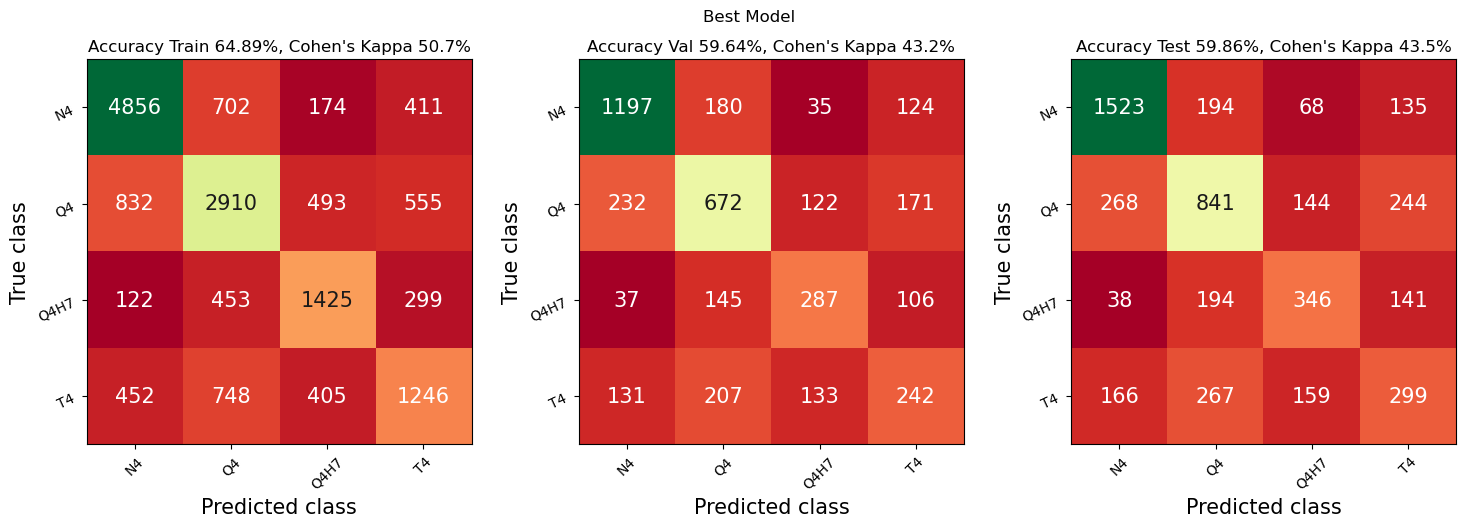

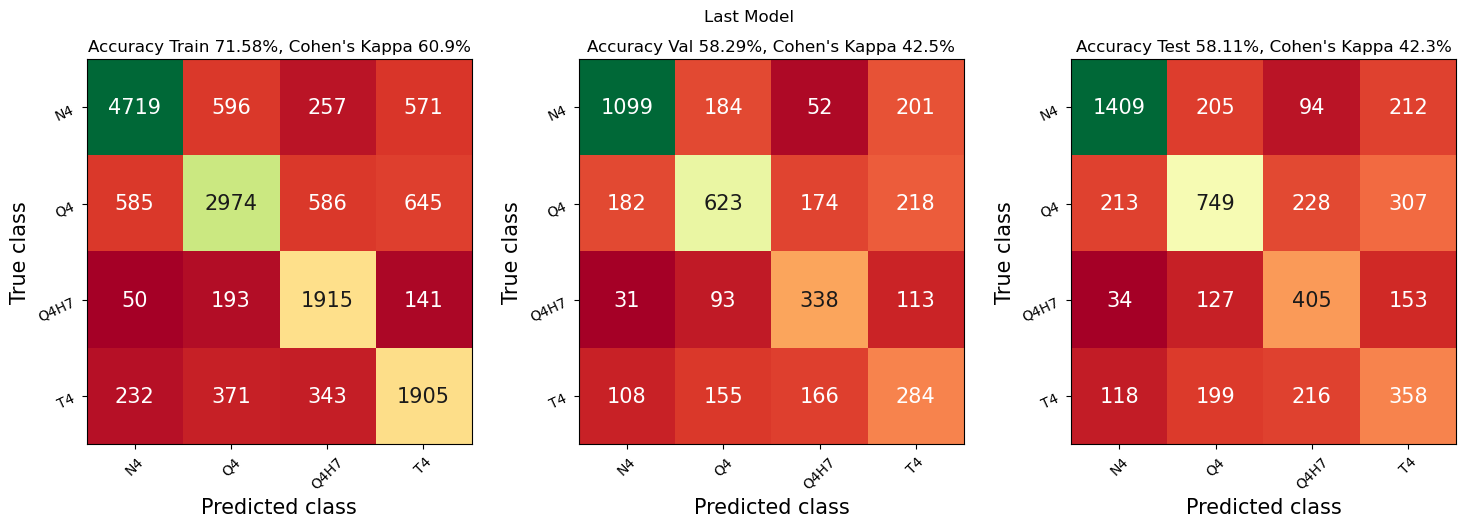

In [4]:
trainer.train(n_epochs)
trainer.test("best")  # Testing on the best model (in term of validation accuracy)
trainer.test("last")  # Testing on the last model

In [38]:
trainer.load_best()
x_val, y_val = dataset.val_batch(True, True)

mean, std = trainer.estimate_uncertainty(x_val, n_samples=250)  # Uncertainty estimation over 500 samples
# mean and std have shape (n_samples, n_classes)
# We define the uncertainty as the standard deviation of the predicted class
# Or as the mean of the standard deviation of each class
# Or as the maximum of the standard deviation of each class

# predicted_class = torch.argmax(mean, 1)
# uncertainty = std[range(std.shape[0]), predicted_class]
uncertainty = std.mean(1)

In [39]:
thresholds = torch.linspace(0.0, 0.95, 5).cuda()
for t in thresholds:
    quantile = torch.quantile(uncertainty, t)  # 95% quantile of the uncertainty
    n_uncertain = (uncertainty < quantile).sum()
    print(f"Number of uncertain samples with a quantile of {t:.2f} ({quantile:.2f}): {n_uncertain}")
    x_filtered = x_val[uncertainty > quantile]
    y_filtered = y_val[uncertainty > quantile]
    print(f"Number of samples after removing uncertains: {len(x_filtered)}")
    loss, scores = trainer.eval(x_filtered, y_filtered)
    kappa = scores["CohenKappa"]
    accuracy = scores["Accuracy"]
    print(f"Accuracy: {accuracy:.2%} - Kappa {kappa:.2f}")
    print(50 * "-")


Number of uncertain samples with a quantile of 0.00 (0.03): 0
Number of samples after removing uncertains: 4020
Accuracy: 59.63% - Kappa 0.43
--------------------------------------------------
Number of uncertain samples with a quantile of 0.24 (0.07): 955
Number of samples after removing uncertains: 3066
Accuracy: 66.08% - Kappa 0.50
--------------------------------------------------
Number of uncertain samples with a quantile of 0.47 (0.10): 1910
Number of samples after removing uncertains: 2111
Accuracy: 74.51% - Kappa 0.58
--------------------------------------------------
Number of uncertain samples with a quantile of 0.71 (0.13): 2865
Number of samples after removing uncertains: 1156
Accuracy: 87.89% - Kappa 0.69
--------------------------------------------------
Number of uncertain samples with a quantile of 0.95 (0.18): 3819
Number of samples after removing uncertains: 201
Accuracy: 97.51% - Kappa 0.00
--------------------------------------------------
